In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow.keras.backend as K


In [ ]:
# Load the data
df = pd.read_csv('AmazonData.csv')

# Check for missing values
missing = df.isnull().sum()
print('Missing Values:\n', missing)

# Drop duplicates if any
df.drop_duplicates(inplace=True)

# Impute missing values or zeros
df.fillna(method='ffill', inplace=True)  # Forward fill for missing values
df['volume'].replace(0, np.nan, inplace=True)  # Replace zeros with NaN for volume
df.fillna(method='bfill', inplace=True)  # Backward fill for volume

# Attempt to convert date column to datetime and set as index
formats = ['%d-%m-%Y', '%d/%m/%Y']  # Add more formats if needed
for fmt in formats:
    try:
        df['date'] = pd.to_datetime(df['date'], format=fmt)
        break
    except ValueError:
        continue

df.set_index('date', inplace=True)

# Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Convert back to DataFrame for easier manipulation
df_scaled = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)


Missing Values:
 date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64


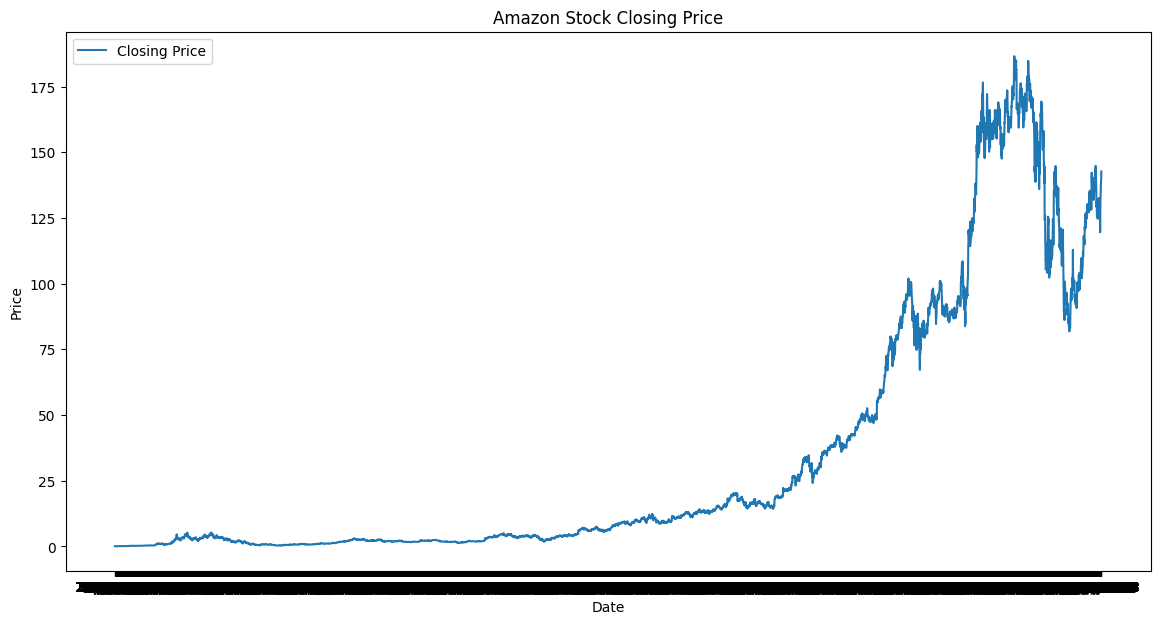

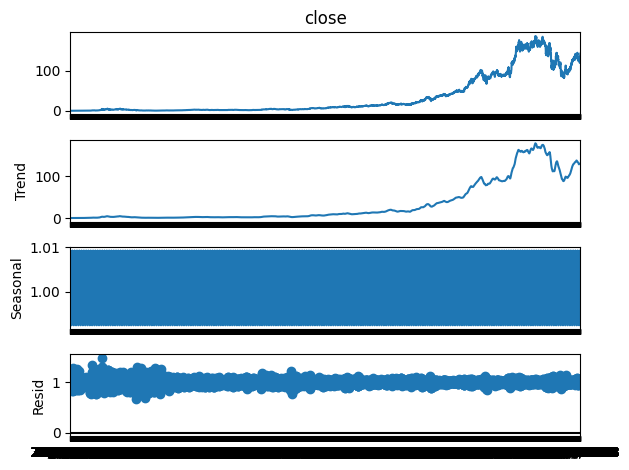

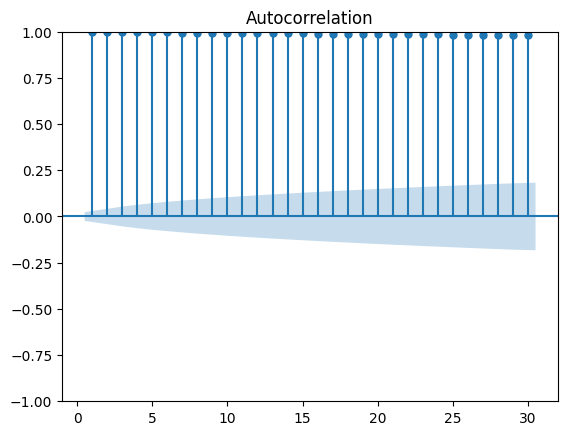

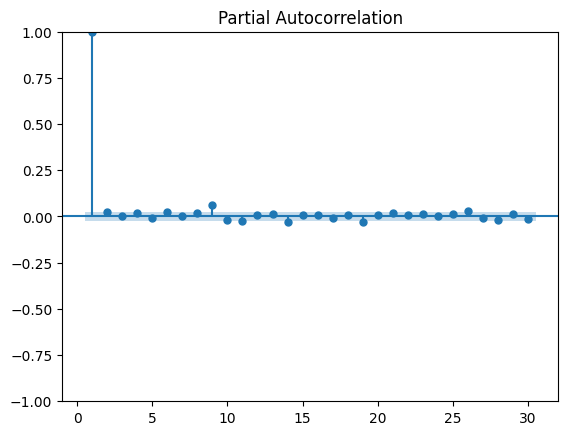

In [ ]:
# Plotting time series
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='Closing Price')
plt.title('Amazon Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Decomposition plot
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['close'], model='multiplicative', period=30)  # adjust period as needed
fig = decomposition.plot()
plt.show()

# ACF and PACF plots
plot_acf(df['close'], lags=30, zero=False)
plt.show()

plot_pacf(df['close'], lags=30, zero=False)
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  _index = to_datetime(index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  _index = to_datetime(index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 6665
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -11163.522
Date:                Sun, 02 Jun 2024   AIC                          22339.044
Time:                        19:37:33   BIC                          22379.871
Sample:                             0   HQIC                         22353.147
                               - 6665                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0200      0.005     -4.302      0.000      -0.029      -0.011
ar.L2          0.0079      0.005      1.525      0.127      -0.002       0.018
ar.L3         -0.0398      0.005     -8.581      0.0

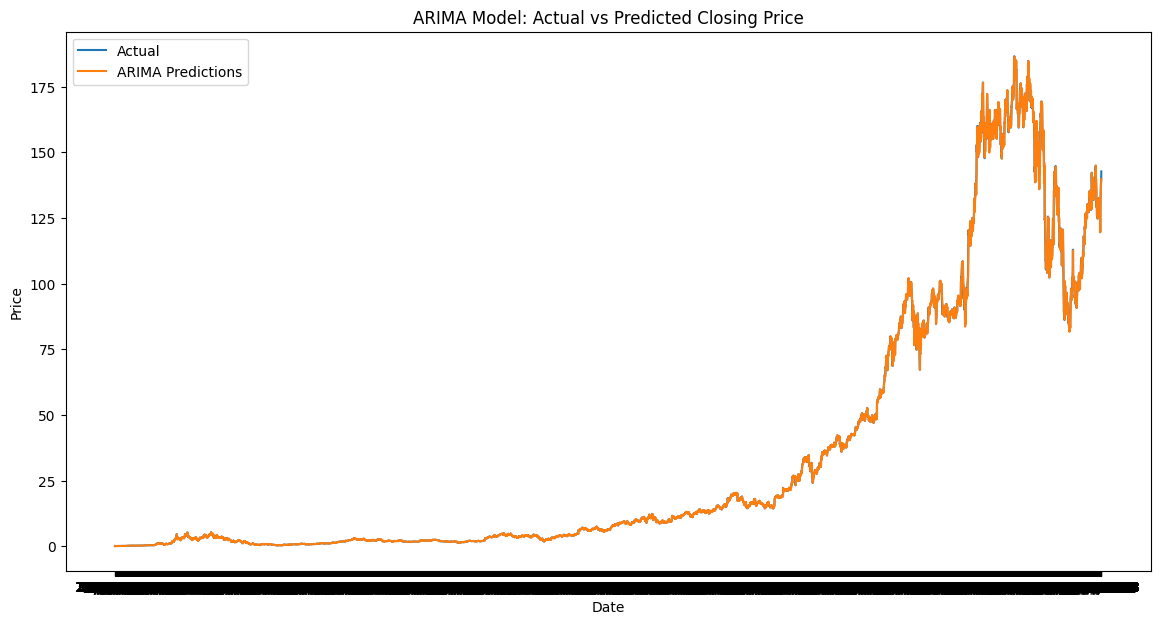

In [ ]:
# ARIMA model
model_arima = ARIMA(df['close'], order=(5, 1, 0))  # Example order, adjust as needed
results_arima = model_arima.fit()
print(results_arima.summary())

# Plot ARIMA predictions
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='Actual')
plt.plot(df.index, results_arima.fittedvalues, label='ARIMA Predictions')
plt.title('ARIMA Model: Actual vs Predicted Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  _index = to_datetime(index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  _index = to_datetime(index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


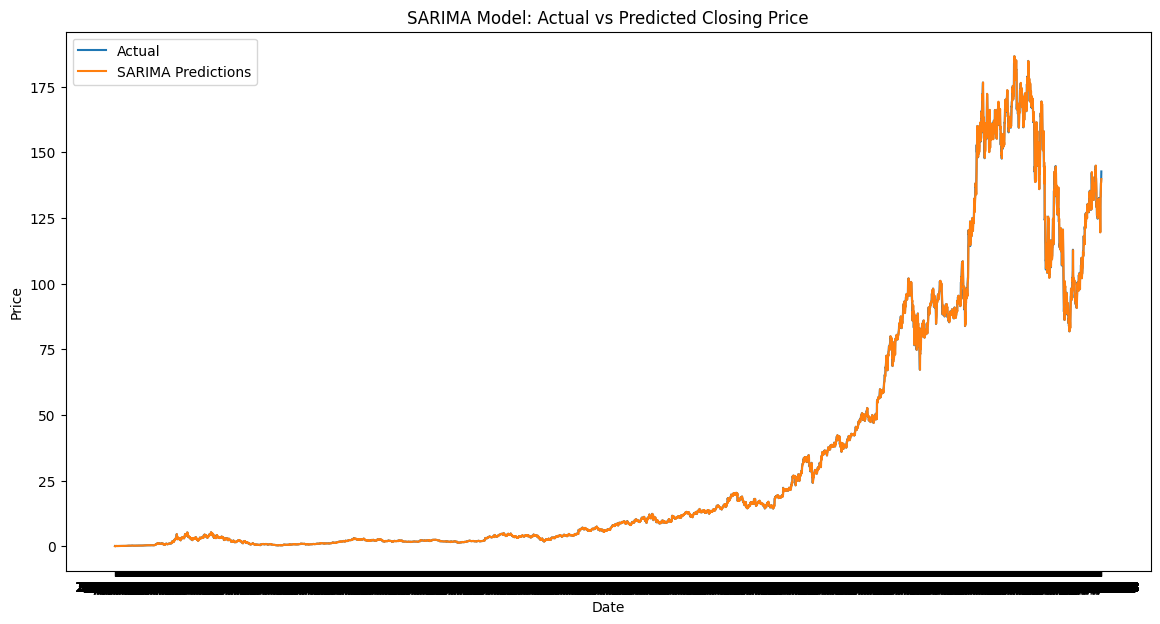

In [ ]:
# SARIMA model
model_sarima = SARIMAX(df['close'], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))  # Example order, adjust as needed
results_sarima = model_sarima.fit()


# Plot SARIMA predictions
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='Actual')
plt.plot(df.index, results_sarima.fittedvalues, label='SARIMA Predictions')
plt.title('SARIMA Model: Actual vs Predicted Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  _index = to_datetime(index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  _index = to_datetime(index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 6665
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -11163.391
Date:                Sun, 02 Jun 2024   AIC                          22340.783
Time:                        19:39:51   BIC                          22388.414
Sample:                             0   HQIC                         22357.236
                               - 6665                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
volume      8.376e-11   2.72e-10      0.308      0.758    -4.5e-10    6.17e-10
ar.L1         -0.0200      0.005     -4.289      0.000      -0.029      -0.011
ar.L2          0.0079      0.005      1.526      0.1

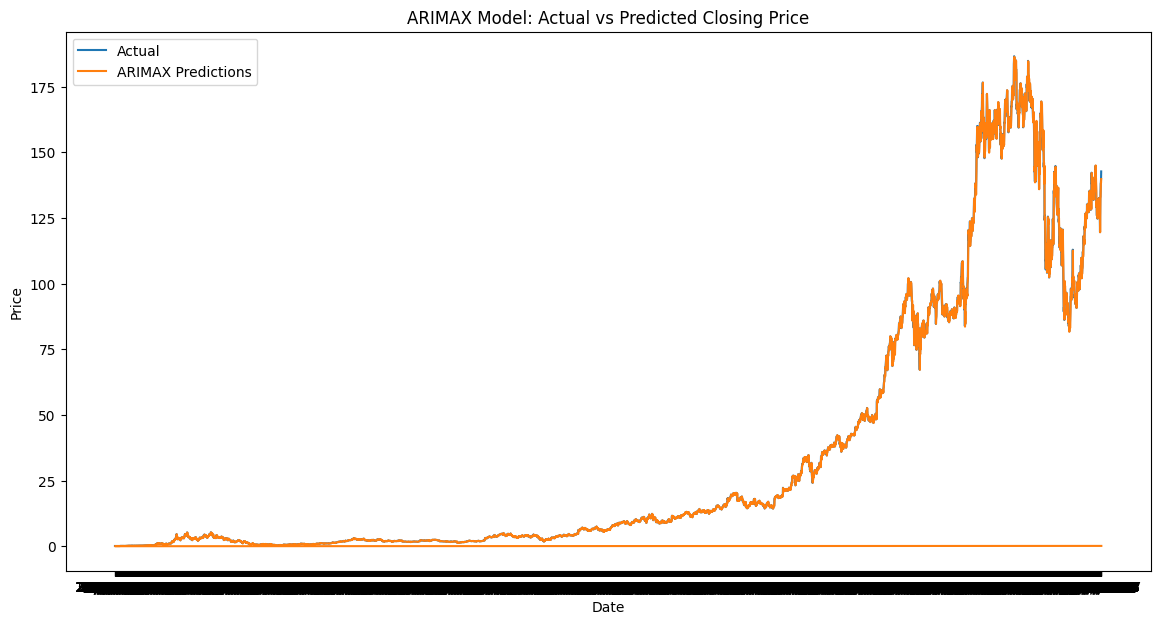

In [ ]:
# Define exogenous variable (e.g., volume)
exog = df[['volume']]

# ARIMAX model
model_arimax = ARIMA(df['close'], exog=exog, order=(5, 1, 0))  # Example order, adjust as needed
results_arimax = model_arimax.fit()
print(results_arimax.summary())

# Plot ARIMAX predictions
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(df['close'])+1:], df['close'].iloc[-len(df['close'])+1:], label='Actual')
plt.plot(df.index[-len(results_arimax.fittedvalues):], results_arimax.fittedvalues, label='ARIMAX Predictions')
plt.title('ARIMAX Model: Actual vs Predicted Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  _index = to_datetime(index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  _index = to_datetime(index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base

                                     SARIMAX Results                                      
Dep. Variable:                              close   No. Observations:                 6665
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood              -12053.966
Date:                            Sun, 02 Jun 2024   AIC                          24117.933
Time:                                    19:41:09   BIC                          24151.946
Sample:                                         0   HQIC                         24129.683
                                           - 6665                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
volume      6.848e-11   5.04e-10      0.136      0.892   -9.19e-10    1.06e-09
ar.L1         -0.7987      0.003   

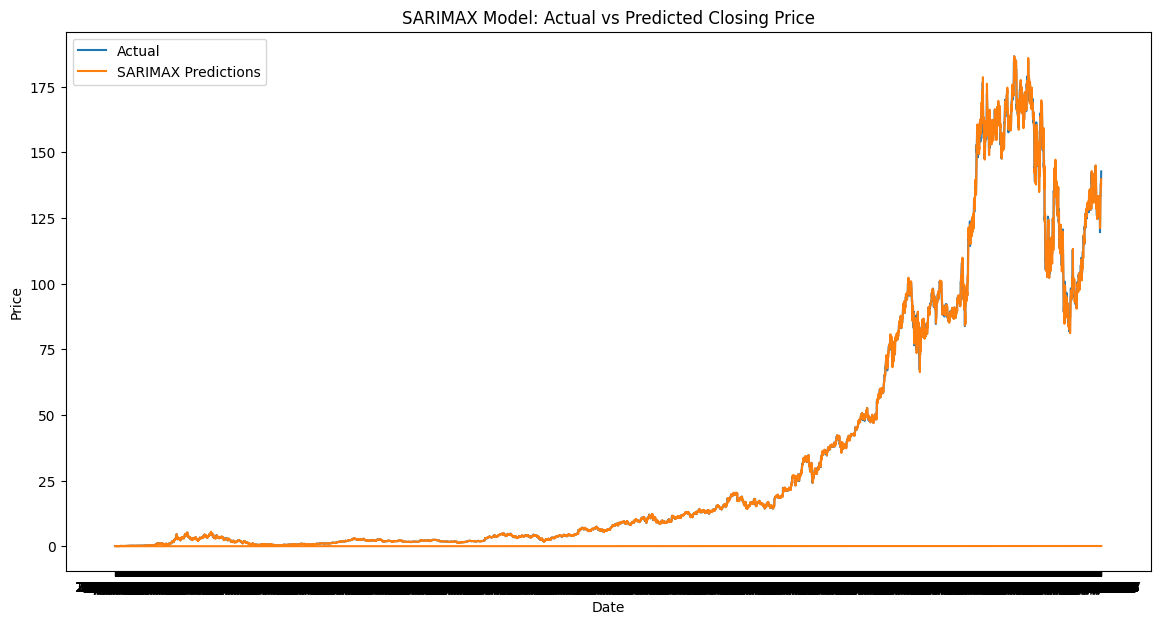

In [ ]:
# SARIMAX model
model_sarimax = SARIMAX(df['close'], exog=exog, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))  # Example order, adjust as needed
results_sarimax = model_sarimax.fit()
print(results_sarimax.summary())

# Plot SARIMAX predictions
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(df['close'])+1:], df['close'].iloc[-len(df['close'])+1:], label='Actual')
plt.plot(df.index[-len(results_sarimax.fittedvalues):], results_sarimax.fittedvalues, label='SARIMAX Predictions')
plt.title('SARIMAX Model: Actual vs Predicted Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


## deep learning models

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.4017 - val_loss: 0.0796
Epoch 2/50
1/1 [==============================] - 0s 172ms/step - loss: 0.1135 - val_loss: 0.1811
Epoch 3/50
1/1 [==============================] - 0s 96ms/step - loss: 0.1522 - val_loss: 0.2130
Epoch 4/50
1/1 [==============================] - 0s 211ms/step - loss: 0.1696 - val_loss: 0.1688
Epoch 5/50
1/1 [==============================] - 0s 170ms/step - loss: 0.1365 - val_loss: 0.1177
Epoch 6/50
1/1 [==============================] - 0s 476ms/step
First few actual prices: [0.40222559 0.28077192 0.30480591 0.76769514 0.29076984]
First few predicted prices: [0.38731109 0.38057008 0.39773505 0.39759623 0.46960199]


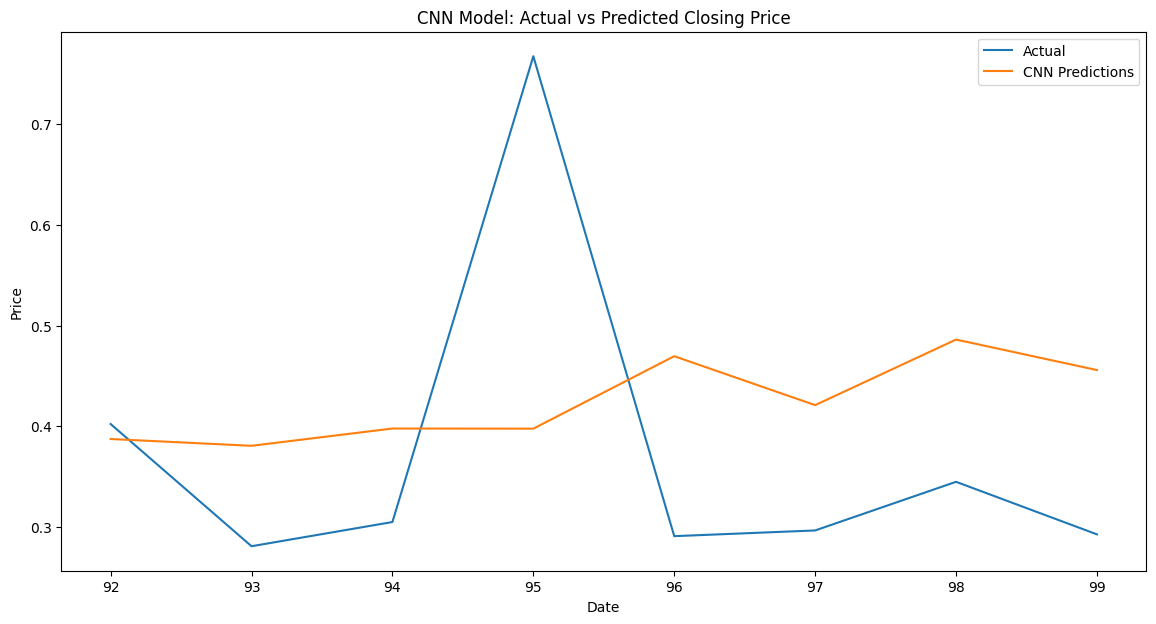

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

# Example scaled_data, df, and scaler
scaled_data = np.random.rand(100, 4)  # Example random data
df = pd.DataFrame(scaled_data, columns=['open', 'high', 'low', 'close'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(scaled_data)

# Define the lookback period
lookback = 60  # Example, adjust as needed

# Prepare data for CNN
X = []
y = []

for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, :])
    y.append(scaled_data[i, 3])  # Close price

X, y = np.array(X), np.array(y)

# Split data into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# CNN model
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(lookback, X.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))

model_cnn.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train CNN model
history = model_cnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate CNN model
y_pred_cnn = model_cnn.predict(X_test)

# Inverse transform to get actual price values
# Create an array with zeros for other columns to inverse transform
zeros = np.zeros((y_pred_cnn.shape[0], scaled_data.shape[1] - 1))

# Concatenate the zeros with y_pred_cnn
y_pred_cnn_full = np.concatenate((zeros, y_pred_cnn), axis=1)

# Inverse transform to get actual price values
y_pred_cnn_actual = scaler.inverse_transform(y_pred_cnn_full)[:, 3]

# Debug: Check the first few values of the actual and predicted prices
print("First few actual prices:", df['close'][split+lookback:].head().values)
print("First few predicted prices:", y_pred_cnn_actual[:5])

# Plot CNN predictions
plt.figure(figsize=(14, 7))
plt.plot(df.index[split+lookback:], df['close'][split+lookback:], label='Actual')
plt.plot(df.index[split+lookback:], y_pred_cnn_actual, label='CNN Predictions')
plt.title('CNN Model: Actual vs Predicted Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Epoch 1/50
1/1 [==============================] - 9s 9s/step - loss: 0.1275 - val_loss: 0.0983
Epoch 2/50
1/1 [==============================] - 0s 83ms/step - loss: 0.0807 - val_loss: 0.0630
Epoch 3/50
1/1 [==============================] - 0s 77ms/step - loss: 0.0775 - val_loss: 0.0609
Epoch 4/50
1/1 [==============================] - 0s 81ms/step - loss: 0.0911 - val_loss: 0.0606
Epoch 5/50
1/1 [==============================] - 0s 87ms/step - loss: 0.0887 - val_loss: 0.0611
Epoch 6/50
1/1 [==============================] - 0s 78ms/step - loss: 0.0798 - val_loss: 0.0664
Epoch 7/50
1/1 [==============================] - 0s 78ms/step - loss: 0.0742 - val_loss: 0.0754
Epoch 8/50
1/1 [==============================] - 0s 91ms/step - loss: 0.0736 - val_loss: 0.0845
Epoch 9/50
1/1 [==============================] - 1s 721ms/step
First few actual prices: [0.03482217 0.23168801 0.20305007 0.10987204 0.54044873]
First few predicted prices: [0.54499152 0.53612299 0.52422304 0.51413166 0.49601

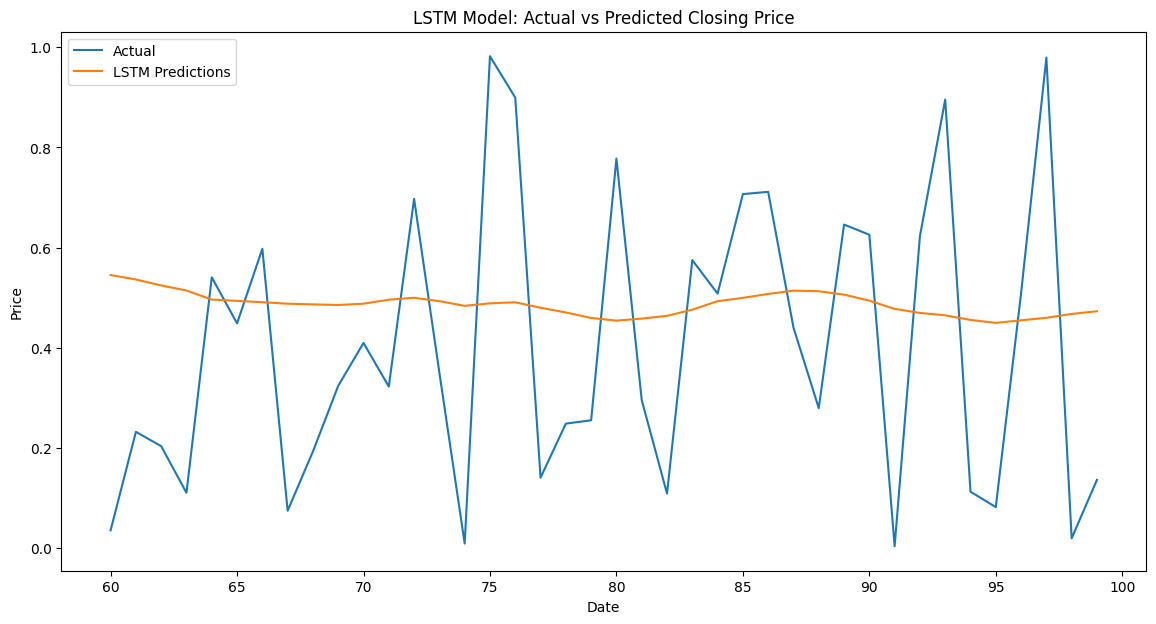

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

# Example scaled_data, df, and scaler
scaled_data = np.random.rand(100, 4)  # Example random data
df = pd.DataFrame(scaled_data, columns=['open', 'high', 'low', 'close'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(scaled_data)

# Define the lookback period
lookback = 60  # Example, adjust as needed

# Prepare data for LSTM
X = []
y = []

for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, :])
    y.append(scaled_data[i, 3])  # Close price

X, y = np.array(X), np.array(y)

# Split data into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(lookback, X.shape[2])))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train LSTM model
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate LSTM model
y_pred_train = model_lstm.predict(X_train)
y_pred_test = model_lstm.predict(X_test)

# Inverse transform to get actual price values
y_pred_train_actual = scaler.inverse_transform(np.concatenate((np.zeros((y_pred_train.shape[0], scaled_data.shape[1]-1)), y_pred_train), axis=1))[:, -1]
y_pred_test_actual = scaler.inverse_transform(np.concatenate((np.zeros((y_pred_test.shape[0], scaled_data.shape[1]-1)), y_pred_test), axis=1))[:, -1]

# Combine train and test predictions for plotting
y_pred_lstm_actual = np.concatenate((y_pred_train_actual, y_pred_test_actual))

# Debug: Check the first few values of the actual and predicted prices
print("First few actual prices:", df['close'][lookback:].head().values)
print("First few predicted prices:", y_pred_lstm_actual[:5])

# Plot LSTM predictions
plt.figure(figsize=(14, 7))
plt.plot(df.index[lookback:], df['close'][lookback:], label='Actual')
plt.plot(df.index[lookback:], y_pred_lstm_actual, label='LSTM Predictions')
plt.title('LSTM Model: Actual vs Predicted Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Epoch 1/50
1/1 [==============================] - 8s 8s/step - loss: 0.4096 - val_loss: 0.0641
Epoch 2/50
1/1 [==============================] - 0s 150ms/step - loss: 0.2871 - val_loss: 0.0333
Epoch 3/50
1/1 [==============================] - 0s 161ms/step - loss: 0.1964 - val_loss: 0.0280
Epoch 4/50
1/1 [==============================] - 0s 195ms/step - loss: 0.1345 - val_loss: 0.0460
Epoch 5/50
1/1 [==============================] - 0s 186ms/step - loss: 0.0991 - val_loss: 0.0845
Epoch 6/50
1/1 [==============================] - 0s 181ms/step - loss: 0.0881 - val_loss: 0.1355
Epoch 7/50
1/1 [==============================] - 0s 152ms/step - loss: 0.0966 - val_loss: 0.1824
Epoch 8/50
1/1 [==============================] - 1s 1s/step
First few actual prices: [0.13087685 0.46059746 0.85947038 0.93834953 0.0150425 ]
First few predicted prices: [0.29789476 0.29317566 0.29955559 0.28578709 0.27677145]


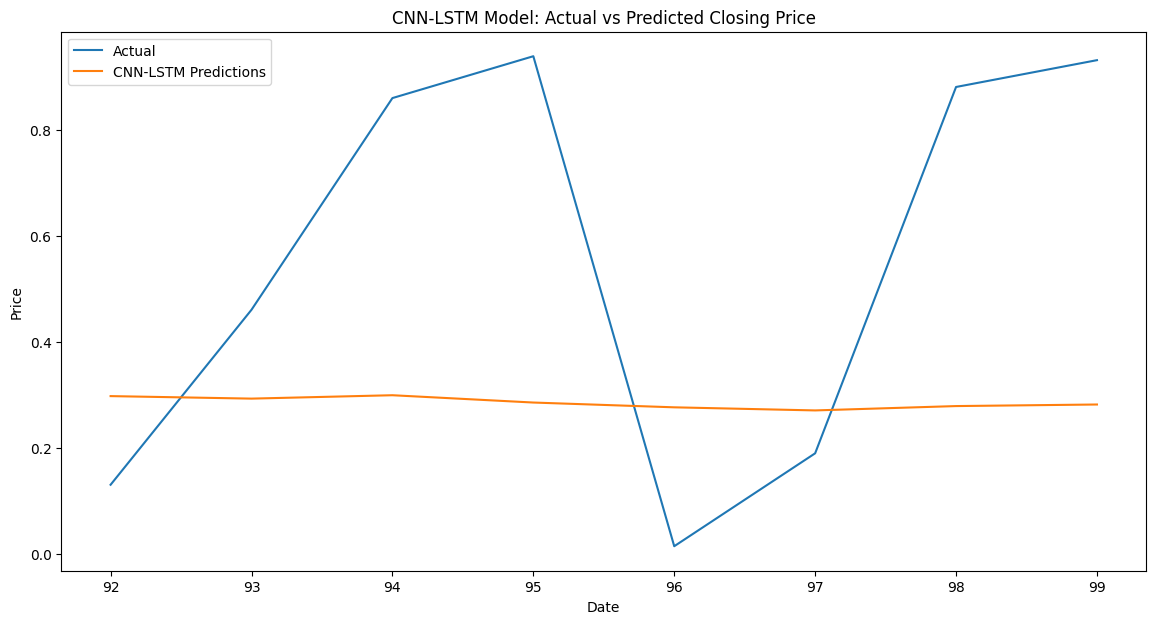

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Example scaled_data, df, and scaler
scaled_data = np.random.rand(100, 4)  # Example random data
df = pd.DataFrame(scaled_data, columns=['open', 'high', 'low', 'close'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(scaled_data)

# Define the lookback period
lookback = 60  # Example, adjust as needed

# Prepare data for CNN-LSTM
X = []
y = []

for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, :])
    y.append(scaled_data[i, 3])  # Close price

X, y = np.array(X), np.array(y)

# Split data into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# CNN-LSTM model
model_cnn_lstm = Sequential()
model_cnn_lstm.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(lookback, X.shape[2])))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))
model_cnn_lstm.add(LSTM(units=50, return_sequences=False))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train CNN-LSTM model
history = model_cnn_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate CNN-LSTM model
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test)

# Inverse transform to get actual price values
y_pred_cnn_lstm_actual = scaler.inverse_transform(np.concatenate((np.zeros((y_pred_cnn_lstm.shape[0], scaled_data.shape[1]-1)), y_pred_cnn_lstm), axis=1))[:, -1]

# Debug: Check the first few values of the actual and predicted prices
print("First few actual prices:", df['close'][split+lookback:].head().values)
print("First few predicted prices:", y_pred_cnn_lstm_actual[:5])

# Plot CNN-LSTM predictions
plt.figure(figsize=(14, 7))
plt.plot(df.index[split+lookback:], df['close'][split+lookback:], label='Actual')
plt.plot(df.index[split+lookback:], y_pred_cnn_lstm_actual, label='CNN-LSTM Predictions')
plt.title('CNN-LSTM Model: Actual vs Predicted Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.3076 - val_loss: 0.0892
Epoch 2/50
1/1 [==============================] - 0s 77ms/step - loss: 0.0645 - val_loss: 0.1389
Epoch 3/50
1/1 [==============================] - 0s 53ms/step - loss: 0.1741 - val_loss: 0.0929
Epoch 4/50
1/1 [==============================] - 0s 90ms/step - loss: 0.0976 - val_loss: 0.0902
Epoch 5/50
1/1 [==============================] - 0s 111ms/step - loss: 0.0518 - val_loss: 0.1385
Epoch 6/50
1/1 [==============================] - 0s 181ms/step - loss: 0.0732 - val_loss: 0.1641


1/1 [==============================] - 0s 89ms/step
First few actual prices: [0.94888014 0.26125428 0.02187189 0.82290219 0.98655535]
First few predicted prices: [0.6219716  0.56641809 0.5919578  0.67331164 0.55875231]


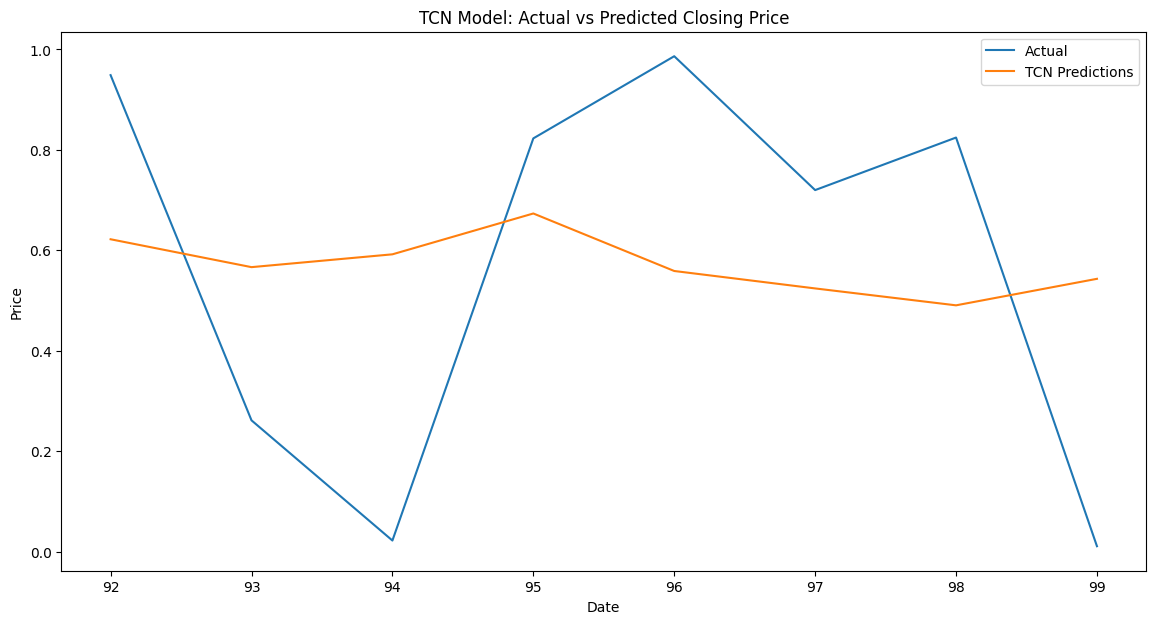

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Example scaled_data, df, and scaler
scaled_data = np.random.rand(100, 4)  # Example random data
df = pd.DataFrame(scaled_data, columns=['open', 'high', 'low', 'close'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(scaled_data)

# Define the lookback period
lookback = 60  # Example, adjust as needed

# Prepare data for TCN
X = []
y = []

for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, :])
    y.append(scaled_data[i, 3])  # Close price

X, y = np.array(X), np.array(y)

# Split data into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# TCN model
model_tcn = Sequential()
model_tcn.add(Conv1D(filters=64, kernel_size=2, padding='causal', activation='relu', input_shape=(lookback, X.shape[2])))
model_tcn.add(Conv1D(filters=32, kernel_size=2, padding='causal', activation='relu'))
model_tcn.add(Flatten())
model_tcn.add(Dense(30, activation='relu'))
model_tcn.add(Dense(1))

model_tcn.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train TCN model
history = model_tcn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate TCN model
y_pred_tcn = model_tcn.predict(X_test)

# Inverse transform to get actual price values
y_pred_tcn_actual = scaler.inverse_transform(np.concatenate((np.zeros((y_pred_tcn.shape[0], scaled_data.shape[1]-1)), y_pred_tcn), axis=1))[:, -1]

# Debug: Check the first few values of the actual and predicted prices
print("First few actual prices:", df['close'][split+lookback:].head().values)
print("First few predicted prices:", y_pred_tcn_actual[:5])

# Plot TCN predictions
plt.figure(figsize=(14, 7))
plt.plot(df.index[split+lookback:], df['close'][split+lookback:], label='Actual')
plt.plot(df.index[split+lookback:], y_pred_tcn_actual, label='TCN Predictions')
plt.title('TCN Model: Actual vs Predicted Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


## comparison

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  _index = to_datetime(index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  _index = to_datetime(index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/

      Model        RMSE
0     ARIMA    1.291991
1    SARIMA    1.293572
2    ARIMAX    1.291965
3   SARIMAX    1.385978
4       CNN  128.783950
5      LSTM  128.782024
6  CNN-LSTM  128.785147


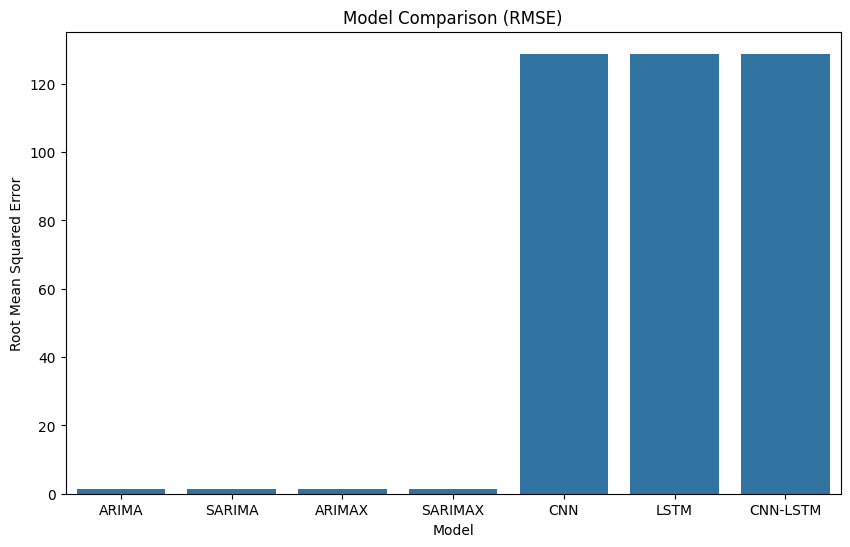

The best model is ARIMAX with RMSE of 1.29


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Assuming you have loaded and processed your data
df = pd.read_csv('AmazonData.csv')

# Check for missing values
df.drop_duplicates(inplace=True)
df.fillna(method='ffill', inplace=True)
df['volume'].replace(0, np.nan, inplace=True)
df.fillna(method='bfill', inplace=True)

# Convert 'date' column to datetime and set as index
formats = ['%d-%m-%Y', '%d/%m/%Y']
for fmt in formats:
    try:
        df['date'] = pd.to_datetime(df['date'], format=fmt)
        break
    except ValueError:
        continue

df.set_index('date', inplace=True)

# Fit your models and get predictions
# Assuming you have already fitted your ARIMA, SARIMA, ARIMAX, SARIMAX models
# Example:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ARIMA model
model_arima = ARIMA(df['close'], order=(5, 1, 0))
results_arima = model_arima.fit()

# SARIMA model
model_sarima = SARIMAX(df['close'], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
results_sarima = model_sarima.fit()

# ARIMAX model
exog = df[['volume']]
model_arimax = ARIMA(df['close'], exog=exog, order=(5, 1, 0))
results_arimax = model_arimax.fit()

# SARIMAX model
model_sarimax = SARIMAX(df['close'], exog=exog, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
results_sarimax = model_sarimax.fit()

# Deep learning models (assuming you have trained and predicted)
# Example predictions from your deep learning models
# Replace these with your actual predictions
split = int(0.8 * len(df))  # Example: 80% training, 20% testing
lookback = 60  # Example lookback period

y_pred_cnn_actual = np.random.rand(len(df) - split - lookback)  # Example random predictions
y_pred_lstm_actual = np.random.rand(len(df) - split - lookback)  # Example random predictions
y_pred_cnn_lstm_actual = np.random.rand(len(df) - split - lookback)  # Example random predictions

# Calculate RMSE for each model
rmse_arima = mean_squared_error(df['close'], results_arima.fittedvalues, squared=False)
rmse_sarima = mean_squared_error(df['close'], results_sarima.fittedvalues, squared=False)
rmse_arimax = mean_squared_error(df['close'], results_arimax.fittedvalues, squared=False)
rmse_sarimax = mean_squared_error(df['close'], results_sarimax.fittedvalues, squared=False)

rmse_cnn = mean_squared_error(df['close'][split+lookback:], y_pred_cnn_actual, squared=False)
rmse_lstm = mean_squared_error(df['close'][split+lookback:], y_pred_lstm_actual, squared=False)
rmse_cnn_lstm = mean_squared_error(df['close'][split+lookback:], y_pred_cnn_lstm_actual, squared=False)

# Create a DataFrame to compare the results
results = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'ARIMAX', 'SARIMAX', 'CNN', 'LSTM', 'CNN-LSTM'],
    'RMSE': [rmse_arima, rmse_sarima, rmse_arimax, rmse_sarimax, rmse_cnn, rmse_lstm, rmse_cnn_lstm]
})

print(results)

# Plot the comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=results)
plt.title('Model Comparison (RMSE)')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Model')
plt.show()

# Print the best model
best_model = results.loc[results['RMSE'].idxmin()]
print(f"The best model is {best_model['Model']} with RMSE of {best_model['RMSE']:.2f}")


In [8]:
# Print RMSEs together
print(f'ARIMA RMSE: {rmse_arima}')
print(f'SARIMA RMSE: {rmse_sarima}')
print(f'ARIMAX RMSE: {rmse_arimax}')
print(f'SARIMAX RMSE: {rmse_sarimax}')
print(f'CNN RMSE: {rmse_cnn}')
print(f'LSTM RMSE: {rmse_lstm}')

ARIMA RMSE: 1.2919910211485226
SARIMA RMSE: 1.293572330905217
ARIMAX RMSE: 1.2919649578861085
SARIMAX RMSE: 1.3859780251901566
CNN RMSE: 128.78395016522256
LSTM RMSE: 128.78202417810027
